# `DSML_WS_02` - Data Vipers - `Team Assignment`

Importing the needed Python Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# import seaborn as sns
# sns.set()
# sns.set_style("white")
# sns.set_palette("GnBu_d")

# also import these "new" libraries 
# Note: you may have to download an add them to your environment (using e.g. 'conda install -c conda-forge folium')

import folium
from folium import plugins
from folium.plugins import HeatMap
from datetime import datetime #for working with times objects
from datetime import timedelta #for working with times objects
import math
import random
from pathlib import Path

import geopy
from geopy.geocoders import GoogleV3
from geopy.distance import geodesic

## Task 1 Customer Behavior Analytics:

1) Data Preparation
2) Data Cleaning
3) More Data Preperation
4) Visualizing Data and Distributions
5) Clustering

### 1.1) Data preparation

We are working with the provided dataframe 

Formatting the datetime columns from string to datetime format

In [2]:
df = pd.read_csv("../boston_2016.csv")
df["start_time"] = pd.to_datetime(df["start_time"],format="%Y-%m-%d %H:%M:%S") # FORMAT %Y-%m-%d %H:%M:%S beachte - und :
df["end_time"] = pd.to_datetime(df["end_time"],format="%Y-%m-%d %H:%M:%S")

In [3]:
df.head(1)

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type
0,2016-01-01 00:08:07,2016-01-01 00:40:26,36,19,Boston Public Library - 700 Boylston St.,Buswell St. at Park Dr.,1406,Subscriber


In [4]:
print(len(df["bike_id"].unique()))

1802


In [5]:
print(len(df["start_station_name"].unique()))

276


In [6]:
print(len(df["start_station_id"].unique()))

189


There are redundant station_names in the data frame, therfore we are working with the station ID's as they are unique

We are also taking information from the official BlueBikes Boston dataframes:

https://www.bluebikes.com/system-data

In [7]:
df_bluebikes_01 = pd.read_csv("Bluebikes_Trip_data/201601-hubway-tripdata.csv")
df_bluebikes_02 = pd.read_csv("Bluebikes_Trip_data/201602-hubway-tripdata.csv")
df_bluebikes_03 = pd.read_csv("Bluebikes_Trip_data/201603-hubway-tripdata.csv")
df_bluebikes_04 = pd.read_csv("Bluebikes_Trip_data/201604-hubway-tripdata.csv")
df_bluebikes_05 = pd.read_csv("Bluebikes_Trip_data/201605-hubway-tripdata.csv")
df_bluebikes_06 = pd.read_csv("Bluebikes_Trip_data/201606-hubway-tripdata.csv")
df_bluebikes_07 = pd.read_csv("Bluebikes_Trip_data/201607-hubway-tripdata.csv")
df_bluebikes_08 = pd.read_csv("Bluebikes_Trip_data/201608-hubway-tripdata.csv")
df_bluebikes_09 = pd.read_csv("Bluebikes_Trip_data/201609-hubway-tripdata.csv")
df_bluebikes_10 = pd.read_csv("Bluebikes_Trip_data/201610-hubway-tripdata.csv")
df_bluebikes_11 = pd.read_csv("Bluebikes_Trip_data/201611-hubway-tripdata.csv")
df_bluebikes_12 = pd.read_csv("Bluebikes_Trip_data/201612-hubway-tripdata.csv")

In [8]:
df_bluebikes_all = pd.concat([df_bluebikes_01, 
                            df_bluebikes_02,
                            df_bluebikes_03,
                            df_bluebikes_03,
                            df_bluebikes_04,
                            df_bluebikes_05,
                            df_bluebikes_06,
                            df_bluebikes_07,
                            df_bluebikes_08,
                            df_bluebikes_09,
                            df_bluebikes_10,
                            df_bluebikes_11,
                            df_bluebikes_12], axis=0)

In [9]:
print(len(df_bluebikes_all["start station id"].unique()))

189


the amount of unique station ID's matches the one from our data frame

We are using the following data from these dataframes:
- start station latitude
- end station latitude
- start station longitude
- end station longitude

from all unique stations (189 in total)

In [10]:
df_bluebikes_all.drop(['tripduration','starttime','stoptime','end station id', 'end station name', 'end station latitude','end station longitude', 'bikeid', 'usertype', 'birth year','gender'], axis=1, inplace=True)

df_bluebikes_all.rename(columns = {'start station id':'start_station_id'}, inplace = True)
df_bluebikes_all.rename(columns = {'start station latitude':'start_station_latitude'}, inplace = True)
df_bluebikes_all.rename(columns = {'start station longitude':'start_station_longitude'}, inplace = True)
df_bluebikes_all.rename(columns = {'start station name':'start_station_name'}, inplace = True)

df_bluebikes_all.sort_values(["start_station_id"],axis=0, ascending=True,inplace=True,na_position='first')
df_bluebikes_all = df_bluebikes_all.drop_duplicates(subset=['start_station_id'])

df_stations = df_bluebikes_all

We are exporting this as "all_station_id.csv" file for easier access.

In [11]:
# filepath = Path('C:/Users/rfrei/Desktop/all_station_id.csv')
# filepath.parent.mkdir(parents=True, exist_ok=True)
# df_stations.to_csv(filepath)

In [12]:
df_stations = df_stations.reset_index()
df_stations.drop(['index'], axis=1, inplace=True)


In [13]:
df_stations.head(1)

,start_station_id,start_station_name,start_station_latitude,start_station_longitude
0,1,18 Dorrance Warehouse,42.387151,-71.075978


Now we are mapping the lat, long of start and end station to our dataframe (warning: this process might be a bit unorthodox but it is working).

In [14]:
df["start_lat"] = pd.to_numeric(df["start_station_id"], downcast="float")
df["start_long"] = pd.to_numeric(df["start_station_id"], downcast="float")
df["end_lat"] = pd.to_numeric(df["end_station_id"], downcast="float")
df["end_long"] = pd.to_numeric(df["end_station_id"], downcast="float")

The columns above are placeholders.

They are used for the  replace methods which are going to place the correct lat, long to the specific row with the matching station ID.

Because we only have 189 stations we were able to prepare the matching ID's and lat, long in a rather manual fasion. But this way it is also very effecient. 

In [15]:
df['start_lat'] = df['start_lat'].replace([1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,29,30,31,32,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,84,85,87,88,89,90,91,92,93,94,95,96,97,98,99,100,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,124,125,126,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,145,146,149,150,151,152,153,158,159,160,161,162,163,167,169,170,171,173,174,175,176,177,178,179,180,183,184,185,186,189,190,192,193,194,195,196,197,199,200,201,202,203,204,205,207,208,209,210,211,212,213,214,215,216,217,218,219],[42.387151,42.340021,42.345392,42.341814,42.361174,42.35328743453294,42.353334,42.351246,42.350406,42.338629,42.335911,42.336437,42.337171,42.361667,42.34807412317439,42.365064,42.347241,42.35977,42.345959,42.352175,42.35892,42.351205,42.341332,42.341522,42.331184,42.363732,42.334073,42.348833,42.34519428944095,42.348706,42.355402,42.349673,42.357402,42.366222,42.33849279283789,42.363871,42.352261,42.352033,42.357143,42.360613,42.344706,42.343864,42.362811,42.356755,42.351146,42.350989,42.3348756,42.34872432400896,42.350851,42.354979,42.347265,42.328654,42.340799,42.355596,42.351356,42.360624982690496,42.348762,42.344023,42.3511,42.3475,42.348607,42.3581,42.36507,42.341598,42.37199165408676,42.383405,42.362613,42.373231,42.373268,42.36346469304347,42.366426,42.386844,42.379637,42.37842,42.3619622,42.352409,42.339335,42.366981,42.378338,42.366621,42.374035,42.379011,42.370677,42.366277,42.3139036,42.320494,42.375603,42.372969,42.373379,42.36919031768079,42.371848,42.385582,42.396969,42.400877,42.346563,42.380287,42.357218503176526,42.325333,42.3625,42.377945,42.36588481543564,42.376369,42.40449,42.39082,42.330716,42.402763,42.387995,42.370803,42.366095,42.397828,42.335741,42.356052,42.335693,42.345733,42.309054,42.320998,42.315692,42.320561,42.377022,42.31756858003556,42.322701,42.310579,42.350413,42.344827,42.344796,42.398365,42.326599,42.361589,42.388966,42.36356015842989,42.396105,42.369885,42.392766,42.336448,42.363796,42.344137,42.358155,42.345901,42.3601,42.3601,42.32797270205962,42.337596,42.3391085,42.309796,42.344792,42.317642,42.378965,42.303469,42.37408991426522,42.310599,42.34900494405213,42.34894857235593,42.38674802045056,42.36264779118595,42.35957320109044,42.35560121327927,42.37478628706384,42.39558845716709,42.35775309465199,42.36544486137399,42.3482032222746,42.3624278429124,42.36559770612416,42.354686,42.33289074055233,42.38614141163957,42.3720597013741,42.31787329345602,42.321678,42.31884382360106,42.33282815812448,42.316873,42.308035,42.309566,42.324069,42.30791912678712,42.35480179069945,42.35057,42.37980321246644,42.38337841883669,42.36489045541549,42.3688385713652,42.369562869377,42.37536686015489,42.37078454600501,42.38244736415864,42.38673178529929,42.351586001198456,42.37430131617823])

In [16]:
df['start_long'] = df['start_long'].replace([1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,29,30,31,32,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,84,85,87,88,89,90,91,92,93,94,95,96,97,98,99,100,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,124,125,126,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,145,146,149,150,151,152,153,158,159,160,161,162,163,167,169,170,171,173,174,175,176,177,178,179,180,183,184,185,186,189,190,192,193,194,195,196,197,199,200,201,202,203,204,205,207,208,209,210,211,212,213,214,215,216,217,218,219],[-71.075978,-71.100812,-71.069616,-71.090179,-71.065142,-71.04438900947571,-71.137313,-71.115639,-71.108279,-71.1065,-71.088496,-71.073089,-71.102797,-71.13802,-71.07657015323639,-71.119233,-71.105301,-71.051601,-71.082578,-71.055547,-71.057629,-71.043983,-71.076847,-71.068922,-71.095171,-71.124565,-71.105221,-71.041747,-71.1016970872879,-71.097009,-71.058087,-71.077303,-71.147782,-71.059914,-71.07401937246323,-71.050877,-71.123831,-71.070627,-71.050699,-71.057452,-71.097515,-71.085918,-71.056067,-71.055407,-71.066289,-71.073644,-71.0790969,-71.08583986759186,-71.089886,-71.063348,-71.088088,-71.084198,-71.081572,-71.07278,-71.059367,-71.0708999633789,-71.082383,-71.057054,-71.0496,-71.0441,-71.13401,-71.093198,-71.1031,-71.123338,-71.12226963043213,-71.107593,-71.084105,-71.120886,-71.118579,-71.10057324171066,-71.105495,-71.09812,-71.095319,-71.105668,-71.0920526,-71.062679,-71.13493,-71.076472,-71.048927,-71.114214,-71.101427,-71.119945,-71.076529,-71.09169,-71.0405121,-71.051122,-71.064608,-71.094445,-71.111075,-71.11714124679565,-71.060292,-71.113341,-71.123024,-71.116772,-71.128374,-71.125107,-71.1138716340065,-71.075354,-71.08822,-71.116865,-71.06454849243164,-71.114025,-71.123413,-71.10942,-71.057044,-71.126908,-71.119084,-71.104412,-71.086388,-71.130516,-71.03877,-71.069849,-71.045859,-71.100694,-71.11543,-71.110833,-71.098634,-71.06198,-71.056605,-71.06403708501603,-71.099533,-71.107341,-71.07655,-71.028664,-71.031614,-71.107818,-71.066498,-71.107437,-71.132788,-71.08216792345047,-71.139459,-71.069957,-71.129042,-71.023739,-71.129164,-71.052608,-71.052163,-71.063187,-71.0589,-71.0589,-71.11089706420898,-71.096391,-71.0514432,-71.092225,-71.044024,-71.056664,-71.068607,-71.085347,-71.06905996799469,-71.053927,-71.1604106426239,-71.15027189254761,-71.11901879310608,-71.10006093978882,-71.10129475593567,-71.10394477844238,-71.13320231437683,-71.14260613918304,-71.10393404960632,-71.08277142047882,-71.0376513004303,-71.08495473861694,-71.06424808502197,-71.053292,-71.11658334732056,-71.07828140258789,-71.07202649116516,-71.08243077993393,-71.091822,-71.06975734233856,-71.08126938343048,-71.091955,-71.081159,-71.072863,-71.083162,-71.06502056121826,-71.15025043487549,-71.166491,-71.02744817733765,-71.01612031481636,-71.0350424052376,-71.03976666949166,-71.03942692279814,-71.03135883808136,-71.04426160454749,-71.0302323102951,-71.00621223455164,-71.04569256305693,-71.03808671246952])

In [17]:
df['end_lat'] = df['end_lat'].replace([1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,29,30,31,32,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,84,85,87,88,89,90,91,92,93,94,95,96,97,98,99,100,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,124,125,126,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,145,146,149,150,151,152,153,158,159,160,161,162,163,167,169,170,171,173,174,175,176,177,178,179,180,183,184,185,186,189,190,192,193,194,195,196,197,199,200,201,202,203,204,205,207,208,209,210,211,212,213,214,215,216,217,218,219],[42.387151,42.340021,42.345392,42.341814,42.361174,42.35328743453294,42.353334,42.351246,42.350406,42.338629,42.335911,42.336437,42.337171,42.361667,42.34807412317439,42.365064,42.347241,42.35977,42.345959,42.352175,42.35892,42.351205,42.341332,42.341522,42.331184,42.363732,42.334073,42.348833,42.34519428944095,42.348706,42.355402,42.349673,42.357402,42.366222,42.33849279283789,42.363871,42.352261,42.352033,42.357143,42.360613,42.344706,42.343864,42.362811,42.356755,42.351146,42.350989,42.3348756,42.34872432400896,42.350851,42.354979,42.347265,42.328654,42.340799,42.355596,42.351356,42.360624982690496,42.348762,42.344023,42.3511,42.3475,42.348607,42.3581,42.36507,42.341598,42.37199165408676,42.383405,42.362613,42.373231,42.373268,42.36346469304347,42.366426,42.386844,42.379637,42.37842,42.3619622,42.352409,42.339335,42.366981,42.378338,42.366621,42.374035,42.379011,42.370677,42.366277,42.3139036,42.320494,42.375603,42.372969,42.373379,42.36919031768079,42.371848,42.385582,42.396969,42.400877,42.346563,42.380287,42.357218503176526,42.325333,42.3625,42.377945,42.36588481543564,42.376369,42.40449,42.39082,42.330716,42.402763,42.387995,42.370803,42.366095,42.397828,42.335741,42.356052,42.335693,42.345733,42.309054,42.320998,42.315692,42.320561,42.377022,42.31756858003556,42.322701,42.310579,42.350413,42.344827,42.344796,42.398365,42.326599,42.361589,42.388966,42.36356015842989,42.396105,42.369885,42.392766,42.336448,42.363796,42.344137,42.358155,42.345901,42.3601,42.3601,42.32797270205962,42.337596,42.3391085,42.309796,42.344792,42.317642,42.378965,42.303469,42.37408991426522,42.310599,42.34900494405213,42.34894857235593,42.38674802045056,42.36264779118595,42.35957320109044,42.35560121327927,42.37478628706384,42.39558845716709,42.35775309465199,42.36544486137399,42.3482032222746,42.3624278429124,42.36559770612416,42.354686,42.33289074055233,42.38614141163957,42.3720597013741,42.31787329345602,42.321678,42.31884382360106,42.33282815812448,42.316873,42.308035,42.309566,42.324069,42.30791912678712,42.35480179069945,42.35057,42.37980321246644,42.38337841883669,42.36489045541549,42.3688385713652,42.369562869377,42.37536686015489,42.37078454600501,42.38244736415864,42.38673178529929,42.351586001198456,42.37430131617823])

In [18]:
df['end_long'] = df['end_long'].replace([1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,29,30,31,32,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,84,85,87,88,89,90,91,92,93,94,95,96,97,98,99,100,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,124,125,126,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,145,146,149,150,151,152,153,158,159,160,161,162,163,167,169,170,171,173,174,175,176,177,178,179,180,183,184,185,186,189,190,192,193,194,195,196,197,199,200,201,202,203,204,205,207,208,209,210,211,212,213,214,215,216,217,218,219],[-71.075978,-71.100812,-71.069616,-71.090179,-71.065142,-71.04438900947571,-71.137313,-71.115639,-71.108279,-71.1065,-71.088496,-71.073089,-71.102797,-71.13802,-71.07657015323639,-71.119233,-71.105301,-71.051601,-71.082578,-71.055547,-71.057629,-71.043983,-71.076847,-71.068922,-71.095171,-71.124565,-71.105221,-71.041747,-71.1016970872879,-71.097009,-71.058087,-71.077303,-71.147782,-71.059914,-71.07401937246323,-71.050877,-71.123831,-71.070627,-71.050699,-71.057452,-71.097515,-71.085918,-71.056067,-71.055407,-71.066289,-71.073644,-71.0790969,-71.08583986759186,-71.089886,-71.063348,-71.088088,-71.084198,-71.081572,-71.07278,-71.059367,-71.0708999633789,-71.082383,-71.057054,-71.0496,-71.0441,-71.13401,-71.093198,-71.1031,-71.123338,-71.12226963043213,-71.107593,-71.084105,-71.120886,-71.118579,-71.10057324171066,-71.105495,-71.09812,-71.095319,-71.105668,-71.0920526,-71.062679,-71.13493,-71.076472,-71.048927,-71.114214,-71.101427,-71.119945,-71.076529,-71.09169,-71.0405121,-71.051122,-71.064608,-71.094445,-71.111075,-71.11714124679565,-71.060292,-71.113341,-71.123024,-71.116772,-71.128374,-71.125107,-71.1138716340065,-71.075354,-71.08822,-71.116865,-71.06454849243164,-71.114025,-71.123413,-71.10942,-71.057044,-71.126908,-71.119084,-71.104412,-71.086388,-71.130516,-71.03877,-71.069849,-71.045859,-71.100694,-71.11543,-71.110833,-71.098634,-71.06198,-71.056605,-71.06403708501603,-71.099533,-71.107341,-71.07655,-71.028664,-71.031614,-71.107818,-71.066498,-71.107437,-71.132788,-71.08216792345047,-71.139459,-71.069957,-71.129042,-71.023739,-71.129164,-71.052608,-71.052163,-71.063187,-71.0589,-71.0589,-71.11089706420898,-71.096391,-71.0514432,-71.092225,-71.044024,-71.056664,-71.068607,-71.085347,-71.06905996799469,-71.053927,-71.1604106426239,-71.15027189254761,-71.11901879310608,-71.10006093978882,-71.10129475593567,-71.10394477844238,-71.13320231437683,-71.14260613918304,-71.10393404960632,-71.08277142047882,-71.0376513004303,-71.08495473861694,-71.06424808502197,-71.053292,-71.11658334732056,-71.07828140258789,-71.07202649116516,-71.08243077993393,-71.091822,-71.06975734233856,-71.08126938343048,-71.091955,-71.081159,-71.072863,-71.083162,-71.06502056121826,-71.15025043487549,-71.166491,-71.02744817733765,-71.01612031481636,-71.0350424052376,-71.03976666949166,-71.03942692279814,-71.03135883808136,-71.04426160454749,-71.0302323102951,-71.00621223455164,-71.04569256305693,-71.03808671246952])

From the lat, long we can create new columns with the coordinates.

In [19]:
df["start_coordinates"] = list(zip(df["start_lat"],df["start_long"]))

In [20]:
df["end_coordinates"] = list(zip(df["end_lat"],df["end_long"]))

Now the lat, long columns are not needed anymore.

In [21]:
 df.drop(['start_lat','end_lat','start_long','end_long'], axis=1, inplace=True)

In [22]:
df.head(1)

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,start_coordinates,end_coordinates
0,2016-01-01 00:08:07,2016-01-01 00:40:26,36,19,Boston Public Library - 700 Boylston St.,Buswell St. at Park Dr.,1406,Subscriber,"(42.349673, -71.077303)","(42.347241, -71.105301)"


Now we are creating new columns for the following trip-level features:
- distance
- duration
- speed

we need the following methods:

In [23]:
def calc_distances(start_point,end_point):
    return geopy.distance.geodesic( start_point, end_point ).km

def calc_durations(end_time,start_time):
    return (end_time - start_time).total_seconds()

The distance between start and end station is calculated using the geopy function.
This gives us the bee-line between two stations. Trips where start and end are equal will therefore have a distance of 0km. (This takes a few minutes)

In [24]:
df['distance_km'] = df.apply(lambda row: calc_distances(row.start_coordinates, row.end_coordinates), axis=1)

The duration can be calculated from the earlier formatted start and end time stamps.

In [25]:
df["duration_sec"] = df.apply(lambda row: calc_durations(row.end_time,row.start_time), axis=1)

Now we can calculate the average speed of each trip:

In [26]:
df["speed_kmh"] = (df["distance_km"]/(df["duration_sec"]/3600))

In [27]:
df.head(1)

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,start_coordinates,end_coordinates,distance_km,duration_sec,speed_kmh
0,2016-01-01 00:08:07,2016-01-01 00:40:26,36,19,Boston Public Library - 700 Boylston St.,Buswell St. at Park Dr.,1406,Subscriber,"(42.349673, -71.077303)","(42.347241, -71.105301)",2.322721,1939.0,4.312426


### 1.2) Data Cleaning

Now we are taking a look at the data and will clean up any errors that might come from bluebikes' data

The station with name "8D OPS 01" and "8D OPS 03" must be a system error:

8D OPS 01 (ID: 158) has the coordinates 45.505086,-73.566921 - which is in canada

8D OPS 03 (ID: 153) has the coordinates 0,0 - which is in the atlantic ocean

we are deleting trips that inlcude these stations:

In [28]:
len(df)

1236203

In [29]:
df = df.drop(df[df['start_station_id'] == 158].index)
df = df.drop(df[df['start_station_id'] == 153].index)
df = df.drop(df[df['end_station_id'] == 158].index)
df = df.drop(df[df['end_station_id'] == 153].index)

# df_stations = df_stations.drop(df_stations[df_stations['start_station_id'] == 158].index)
# df_stations = df_stations.drop(df_stations[df_stations['start_station_id'] == 153].index)

print("df: ",len(df))
print("df_stations: ",len(df_stations))

df:  1236200
df_stations:  189


We have decided that any average speed above 30 km/h can not be achieved with a rental bike in city traffic, therefore we are deleting those:

In [30]:
df = df.drop(df[df['speed_kmh'] > 30].index)
len(df)

1236192

Trips with an average negative speed also don't make sense - we are deleting them:

In [31]:
df = df.drop(df[df['speed_kmh'] < 0].index)
len(df)

1236189

We are also deleting every trip that is longer than 8 hours, it is very likely that these are not real trips but rather a bike that has been forgotten to be locked.

In [32]:
df = df.drop(df[df['duration_sec'] > 28800].index)
len(df)

1233608

### 1.3) More Data preparation

Now we are preparing the data with visualization and clustering in mind.

#### df_stations

##### Trips per Station

In [33]:
Trips_per_Station = []

Since we got the length of our dataframe, we can count how many departures we are now able to use a lambda function to understand the departures at the individual stations.

In [34]:
for i in df_stations.start_station_id:
    Trip = (df.where(lambda x: (x.start_station_id == i), axis = 0))
    Trips_per_Station.append(len(df) - Trip['start_station_id'].isnull().sum())

In [35]:
print(Trips_per_Station)

[78, 4682, 8984, 7078, 11683, 4583, 4161, 9527, 9633, 8583, 8006, 7782, 8781, 2618, 15059, 6572, 7232, 10937, 12085, 31457, 14556, 7714, 8444, 7963, 5012, 3726, 6305, 5392, 9246, 13884, 9458, 16666, 1323, 9057, 9235, 10849, 8637, 13991, 11082, 7783, 10113, 13220, 13982, 8053, 7675, 8577, 2838, 9234, 17112, 11682, 12002, 1489, 779, 14333, 7965, 15834, 12788, 3336, 9641, 2995, 5077, 35611, 24086, 6247, 8798, 5790, 10651, 11774, 23132, 11462, 14270, 2190, 5537, 6478, 21158, 10468, 2928, 9132, 5358, 10353, 13154, 7870, 12048, 14647, 1062, 1532, 5514, 11446, 10042, 9823, 11378, 3528, 10449, 2276, 3213, 6404, 12278, 512, 14403, 8596, 12788, 9476, 1707, 1370, 2449, 3230, 10212, 9703, 7147, 5525, 4015, 8807, 4849, 3602, 2449, 2651, 1052, 1044, 2479, 722, 3708, 2836, 5973, 3418, 4382, 1613, 935, 6157, 2904, 6630, 3138, 6288, 1887, 3028, 6254, 5156, 7585, 6504, 0, 0, 1739, 4677, 5041, 394, 4949, 1078, 2865, 431, 2406, 504, 1051, 1990, 3313, 11739, 15218, 17475, 2402, 404, 782, 565, 4693, 17985, 

To check for completeness, we compare the length of the array with the number of unique stations.

In [36]:
len(Trips_per_Station)

189

Since this is the case, we can enter the 189 entries directly into the dataframe of the stations.

In [37]:
df_stations['amout_of_trips_per_station'] = DasDingo

In [38]:
sum(df_stations['amout_of_trips_per_station'])

1233608

Here you can also clearly see the demand for students.

The most used station is one at MIT

In [39]:
df_stations.sort_values(['amout_of_trips_per_station'],axis=0, ascending=False,inplace=True,na_position='first')

In [40]:
df_stations.head(5)

,start_station_id,start_station_name,start_station_latitude,start_station_longitude,amout_of_trips_per_station
61,67,MIT at Mass Ave / Amherst St,42.358100,-71.093198,35611
19,22,South Station - 700 Atlantic Ave.,42.352175,-71.055547,31457
62,68,Central Square at Mass Ave / Essex St,42.365070,-71.103100,24086
68,74,Harvard Square at Mass Ave/ Dunster,42.373268,-71.118579,23132
74,80,MIT Stata Center at Vassar St / Main St,42.361962,-71.092053,21158


##### Dinstance from city center

In [41]:
df_stations["start_coordinates"] = list(zip(df_stations["start_station_latitude"],df_stations["start_station_longitude"]))

In [42]:
center_point = (42.36041042227672,-71.05799197093351)
type(center_point)

tuple

In [43]:
def calc_distances_from_center(start_coordinates):
    return geopy.distance.geodesic( start_coordinates,center_point).km

In [44]:
df_stations['distance_center_(km)'] = df_stations.apply(lambda row: calc_distances_from_center(row.start_coordinates), axis=1)

In [45]:
df_stations.sort_index(inplace=True)
df_stations.head(1)

,start_station_id,start_station_name,start_station_latitude,start_station_longitude,amout_of_trips_per_station,start_coordinates,distance_center_(km)
0,1,18 Dorrance Warehouse,42.387151,-71.075978,78,"(42.387151, -71.075978)",3.319275


#### df

For the clustering we are creating two new features: 
- start station distance from the city center
- end station distance from the city center

These are very useful for determining where a trip has started and ended.

We are again using these "manual" replace methods as we only have to add 187 unique values: 

In [46]:
df["start_distance_center"] = pd.to_numeric(df["start_station_id"], downcast="float")
df['start_distance_center'] = df['start_distance_center'].replace([1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,29,30,31,32,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,84,85,87,88,89,90,91,92,93,94,95,96,97,98,99,100,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,124,125,126,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,145,146,149,150,151,152,153,158,159,160,161,162,163,167,169,170,171,173,174,175,176,177,178,179,180,183,184,185,186,189,190,192,193,194,195,196,197,199,200,201,202,203,204,205,207,208,209,210,211,212,213,214,215,216,217,218,219],[3.319274536957586,4.1925465912009425,1.9236113959222407,3.36158328176426,0.5951027715279874,1.3718584965133345,6.582064660303654,4.8572719961183815,4.289507334305973,4.672127506031023,3.704521116556498,2.939187826624499,4.5047893609953515,6.594248754784122,2.05442487758448,5.071361349287967,4.1632693962289435,0.5312852924906886,2.584610624890342,0.9367073810973997,0.16823530294678202,1.5419749489568133,2.627668711831343,2.283235338944895,4.463751921350105,5.4966454730103536,4.8686322934192905,1.8561230946642178,3.9778788149267386,3.4675472072013167,0.5563918225967195,1.9884360834105614,7.404767049772989,0.6646853696629188,2.7697110629371102,0.7009346465441912,5.4992924676229915,1.3962653004526964,0.7019381593422324,0.04985126119504434,3.6941963361830634,2.9448723364401976,0.31024710411954176,0.45850275858499456,1.235437515131699,1.6607631112163037,3.327066457690298,2.6361272481931675,2.8341234567623865,0.7474673246460856,2.8776160031617666,4.135994177841228,2.9189569924379533,1.330515604450698,1.0121268970103436,1.063646343348046,2.390088204279554,1.8219567139232307,1.2440273507935085,1.834839703304569,6.39883838866267,2.911714632904851,3.751808234761259,5.775418757472539,5.448849685699467,4.818218679270047,2.165064082985522,5.37295327618513,5.191087345939687,3.524196824582678,3.969830669477492,4.421018814492567,3.7435700488069075,4.407255602456548,2.8112241743213238,0.9690594603544959,6.7577918281195615,1.6882543553085483,2.126786382766547,4.682530676682679,3.884782952864341,5.505452396854765,1.9058418303470508,2.8514318606477227,5.363061914723275,4.469909333674339,1.7734101302355052,3.3109855270145805,4.60379869888554,4.969119695561541,1.284539907307756,5.347986877389787,6.721373836714284,6.606000145638279,5.999358230914682,5.952773058601211,4.617206162638111,4.150764756860341,2.5009863370111476,5.225917344381738,0.8133295096597801,4.944220388952593,7.280173724221451,5.417699535449694,3.299381184722451,7.371851218788853,5.891295376949093,3.9942993787092975,2.422932572722438,7.276716781871105,3.1650761615519447,1.0902259187118508,2.921959349592853,3.8776715425698223,7.412938526915765,6.1747730372337974,5.99101970110232,4.438653167349732,1.8487548518814403,4.784870624723547,5.409646388332889,6.868777847912298,1.8897003913912853,2.9724234322318175,2.780590018695162,5.883335218421322,3.8206175910825833,4.075425886217481,6.929082161440743,2.022102353251452,7.793472541988049,1.4419030408538378,6.867309184295081,3.8795052054058665,5.875156807588726,1.8612874660996686,0.5416336293667842,1.6675759805536159,0.08236985594742767,0.08236985594742767,5.655827728382,4.053746489787602,2.426963138965921,6.290415600618327,2.081901268632164,4.751971168122593,2.238845143321019,6.714847876747223,1.77204683484134,5.543175689003397,8.532755562112904,7.708725612094792,5.815855498949218,3.4745472901506314,3.5685884445186513,3.823314939632896,6.397737207804816,7.989504488929313,3.7963545181645038,2.1165058229399905,2.155731861858681,2.2324762885417417,0.773056364637191,0.7444873610690533,5.714299238746588,3.3109013946074373,1.7352154808562676,5.136335924528769,5.126653492409666,4.717914784795355,3.614695108631244,5.587662338110994,6.123146177842336,5.779237460888748,4.538485667572326,5.859425095169567,7.6262278925067095,9.005603974832427,3.312092507480438,4.2899317716343255,1.9549543923839896,1.7693115509782562,1.8364022343498916,2.7519062763076314,1.6146767789784822,3.349642740340357,5.1707964140593194,1.4098358672329185,2.2515126294199335])

In [47]:
df["end_distance_center"] = pd.to_numeric(df["end_station_id"], downcast="float")
df['end_distance_center'] = df['end_distance_center'].replace([1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,29,30,31,32,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,84,85,87,88,89,90,91,92,93,94,95,96,97,98,99,100,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,124,125,126,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,145,146,149,150,151,152,153,158,159,160,161,162,163,167,169,170,171,173,174,175,176,177,178,179,180,183,184,185,186,189,190,192,193,194,195,196,197,199,200,201,202,203,204,205,207,208,209,210,211,212,213,214,215,216,217,218,219],[3.319274536957586,4.1925465912009425,1.9236113959222407,3.36158328176426,0.5951027715279874,1.3718584965133345,6.582064660303654,4.8572719961183815,4.289507334305973,4.672127506031023,3.704521116556498,2.939187826624499,4.5047893609953515,6.594248754784122,2.05442487758448,5.071361349287967,4.1632693962289435,0.5312852924906886,2.584610624890342,0.9367073810973997,0.16823530294678202,1.5419749489568133,2.627668711831343,2.283235338944895,4.463751921350105,5.4966454730103536,4.8686322934192905,1.8561230946642178,3.9778788149267386,3.4675472072013167,0.5563918225967195,1.9884360834105614,7.404767049772989,0.6646853696629188,2.7697110629371102,0.7009346465441912,5.4992924676229915,1.3962653004526964,0.7019381593422324,0.04985126119504434,3.6941963361830634,2.9448723364401976,0.31024710411954176,0.45850275858499456,1.235437515131699,1.6607631112163037,3.327066457690298,2.6361272481931675,2.8341234567623865,0.7474673246460856,2.8776160031617666,4.135994177841228,2.9189569924379533,1.330515604450698,1.0121268970103436,1.063646343348046,2.390088204279554,1.8219567139232307,1.2440273507935085,1.834839703304569,6.39883838866267,2.911714632904851,3.751808234761259,5.775418757472539,5.448849685699467,4.818218679270047,2.165064082985522,5.37295327618513,5.191087345939687,3.524196824582678,3.969830669477492,4.421018814492567,3.7435700488069075,4.407255602456548,2.8112241743213238,0.9690594603544959,6.7577918281195615,1.6882543553085483,2.126786382766547,4.682530676682679,3.884782952864341,5.505452396854765,1.9058418303470508,2.8514318606477227,5.363061914723275,4.469909333674339,1.7734101302355052,3.3109855270145805,4.60379869888554,4.969119695561541,1.284539907307756,5.347986877389787,6.721373836714284,6.606000145638279,5.999358230914682,5.952773058601211,4.617206162638111,4.150764756860341,2.5009863370111476,5.225917344381738,0.8133295096597801,4.944220388952593,7.280173724221451,5.417699535449694,3.299381184722451,7.371851218788853,5.891295376949093,3.9942993787092975,2.422932572722438,7.276716781871105,3.1650761615519447,1.0902259187118508,2.921959349592853,3.8776715425698223,7.412938526915765,6.1747730372337974,5.99101970110232,4.438653167349732,1.8487548518814403,4.784870624723547,5.409646388332889,6.868777847912298,1.8897003913912853,2.9724234322318175,2.780590018695162,5.883335218421322,3.8206175910825833,4.075425886217481,6.929082161440743,2.022102353251452,7.793472541988049,1.4419030408538378,6.867309184295081,3.8795052054058665,5.875156807588726,1.8612874660996686,0.5416336293667842,1.6675759805536159,0.08236985594742767,0.08236985594742767,5.655827728382,4.053746489787602,2.426963138965921,6.290415600618327,2.081901268632164,4.751971168122593,2.238845143321019,6.714847876747223,1.77204683484134,5.543175689003397,8.532755562112904,7.708725612094792,5.815855498949218,3.4745472901506314,3.5685884445186513,3.823314939632896,6.397737207804816,7.989504488929313,3.7963545181645038,2.1165058229399905,2.155731861858681,2.2324762885417417,0.773056364637191,0.7444873610690533,5.714299238746588,3.3109013946074373,1.7352154808562676,5.136335924528769,5.126653492409666,4.717914784795355,3.614695108631244,5.587662338110994,6.123146177842336,5.779237460888748,4.538485667572326,5.859425095169567,7.6262278925067095,9.005603974832427,3.312092507480438,4.2899317716343255,1.9549543923839896,1.7693115509782562,1.8364022343498916,2.7519062763076314,1.6146767789784822,3.349642740340357,5.1707964140593194,1.4098358672329185,2.2515126294199335])

In [48]:
def get_hour (ts):
    return ts.hour

In [49]:
df['start_hour'] = df.apply(lambda row: get_hour(row.start_time), axis=1)

##### Weekdays and Weekends


For the predicted demand, it is important to know what the demand looks like on weekdays and weekends.

Therefore we are able to extract the day from the timestamp.

In [50]:
def calc_weekday(day):
    return (day).weekday()

In [51]:
df['weekday_start'] = df.apply(lambda row: calc_weekday(row.start_time), axis=1)

In [52]:
df['weekday_end'] = df.apply(lambda row: calc_weekday(row.end_time), axis=1)

In [53]:
df.head(1)

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,start_coordinates,end_coordinates,distance_km,duration_sec,speed_kmh,start_distance_center,end_distance_center,start_hour,weekday_start,weekday_end
0,2016-01-01 00:08:07,2016-01-01 00:40:26,36,19,Boston Public Library - 700 Boylston St.,Buswell St. at Park Dr.,1406,Subscriber,"(42.349673, -71.077303)","(42.347241, -71.105301)",2.322721,1939.0,4.312426,1.988436,4.163269,0,4,4


Since Phyton can return a number correlating to the day (0 equals monday, 4 equals friday, and so on) we are replacing those numbers with day names.

In [ ]:
df['weekday_start'] = df['weekday_start'].replace([0,1,2,3,4,5,6],['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
df['weekday_end'] = df['weekday_end'].replace([0,1,2,3,4,5,6],['Monday','Tuesday','Wednesday','DonneThursdayrstag','Friday','Saturday','Sunday'])

In [ ]:
df.head(1)

To distinguish between weekdays and weekend days, creating a new column for each day in the dataframe.

In [ ]:
df['true_monday'] = (df.apply(lambda x: getTrueWeekday(x.weekday_start, 'Monday'), axis = 1))
df['true_tuesday'] = (df.apply(lambda x: getTrueWeekday(x.weekday_start, 'Tuesday'), axis = 1))
df['true_wednesday'] = (df.apply(lambda x: getTrueWeekday(x.weekday_start, 'Wednesday'), axis = 1))
df['true_thursday'] = (df.apply(lambda x: getTrueWeekday(x.weekday_start, 'Thursday'), axis = 1))
df['true_friday'] = (df.apply(lambda x: getTrueWeekday(x.weekday_start, 'Friday'), axis = 1))
df['true_saturday'] = (df.apply(lambda x: getTrueWeekday(x.weekday_start, 'Saturday'), axis = 1))
df['true_sunday'] = (df.apply(lambda x: getTrueWeekday(x.weekday_start, 'Sunday'), axis = 1))

The problem with the method above is, that is return True and False booleans.

So if the day is a Monday it will return True on column 'true_monday'. Therefore it will obviously return False if its a tuesday.

Since we are grouping by 'start_time'.dt.hour we'll end up with 24 results for monday.
The same goes for each other day.

We separate the values and fill them into arrays.

In [ ]:
mo = df.where(lambda x: (x.true_monday == True), axis = 0).groupby([df['start_time'].dt.hour]).count()
tu = df.where(lambda x: (x.true_tuesday == True), axis = 0).groupby([df['start_time'].dt.hour]).count()
we = df.where(lambda x: (x.true_wednesday == True), axis = 0).groupby([df['start_time'].dt.hour]).count()
th = df.where(lambda x: (x.true_thursday == True), axis = 0).groupby([df['start_time'].dt.hour]).count()
fr = df.where(lambda x: (x.true_friday == True), axis = 0).groupby([df['start_time'].dt.hour]).count()
sa = df.where(lambda x: (x.true_saturday == True), axis = 0).groupby([df['start_time'].dt.hour]).count()
su = df.where(lambda x: (x.true_sunday == True), axis = 0).groupby([df['start_time'].dt.hour]).count()

In [ ]:
monday = []
tuesday = []
wednesday = []
thursday = []
friday = []
saturday = []
sunday = []
for i in range(0, 24):
    monday.append(mo['start_time'][i])
    tuesday.append(tu['start_time'][i])
    wednesday.append(we['start_time'][i])
    thursday.append(th['start_time'][i])
    friday.append(fr['start_time'][i])
    saturday.append(sa['start_time'][i])
    sunday.append(su['start_time'][i])

Then we create a new dataframe with informations we need to plot the results later on.

In [ ]:
df_hourly_amount_per_day = {'Monday':[monday[0],monday[1],monday[2],monday[3],monday[4],monday[5],monday[6],monday[7],
                              monday[8],monday[9],monday[10],monday[11],monday[12],monday[13],monday[14],monday[15],
                                      monday[16],monday[17],monday[18],monday[19],
                              monday[20],monday[21],monday[22],monday[23]],
                            
                            'Tuesday':[tuesday[0],tuesday[1],tuesday[2],tuesday[3],tuesday[4],tuesday[5],tuesday[6],tuesday[7],
                              tuesday[8],tuesday[9],tuesday[10],tuesday[11],tuesday[12],tuesday[13],tuesday[14],tuesday[15],
                                      tuesday[16],tuesday[17],tuesday[18],tuesday[19],
                              tuesday[20],tuesday[21],tuesday[22],tuesday[23]],
                            
                            'Wednesday':[wednesday[0],wednesday[1],wednesday[2],wednesday[3],wednesday[4],wednesday[5],wednesday[6],wednesday[7],
                              wednesday[8],wednesday[9],wednesday[10],wednesday[11],wednesday[12],wednesday[13],wednesday[14],wednesday[15],
                                      wednesday[16],wednesday[17],wednesday[18],wednesday[19],
                              wednesday[20],wednesday[21],wednesday[22],wednesday[23]],
                            
                            'Thursday':[thursday[0],thursday[1],thursday[2],thursday[3],thursday[4],thursday[5],thursday[6],thursday[7],
                                thursday[8],thursday[9],thursday[10],thursday[11],thursday[12],thursday[13],thursday[14],thursday[15],
                                      thursday[16],thursday[17],thursday[18],thursday[19],
                              thursday[20],thursday[21],thursday[22],thursday[23]],
                            
                            'Friday':[friday[0],friday[1],friday[2],friday[3],friday[4],friday[5],friday[6],friday[7],
                              friday[8],friday[9],friday[10],friday[11],friday[12],friday[13],friday[14],friday[15],
                                      friday[16],friday[17],friday[18],friday[19],
                              friday[20],friday[21],friday[22],friday[23]],
                            
                            'Saturday':[saturday[0],saturday[1],saturday[2],saturday[3],saturday[4],saturday[5],saturday[6],saturday[7],
                              saturday[8],saturday[9],saturday[10],saturday[11],saturday[12],saturday[13],saturday[14],saturday[15],
                                      saturday[16],saturday[17],saturday[18],saturday[19],
                              saturday[20],saturday[21],saturday[22],saturday[23]],
                            
                            'Sunday':[sunday[0],sunday[1],sunday[2],sunday[3],sunday[4],sunday[5],sunday[6],sunday[7],
                              sunday[8],sunday[9],sunday[10],sunday[11],sunday[12],sunday[13],sunday[14],sunday[15],
                                      sunday[16],sunday[17],sunday[18],sunday[19],
                              sunday[20],sunday[21],sunday[22],sunday[23]],
                            
                            'Period':[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]}

In [ ]:
df_hourly_amount_per_day = pd.DataFrame(data = df_hourly_amount_per_day)

To get an overview of the the usage in all 12 months, we extract the amount of people per month.

In [ ]:
df['month'] = df.apply(lambda x: get_month(x.start_time), axis = 1)
m = []
for i in range(1, 13):
    m.append(df.where(lambda x: (x.month == i), axis = 0).count())

In [ ]:
df_monthly_amount = {'Amount':[m[0][0],m[1][1],m[2][2],m[3][3],m[4][4],m[5][5],m[6][6],m[7][7],
                              m[8][8],m[9][9],m[10][10],m[11][11]],'Month':['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
                                                                         'Oct', 'Nov', 'Dec']}

Since we dont need this entry in our dataframe anymore we drop this column to minimize the dataframe to the essentials.

In [ ]:
df.drop(['month'], axis=1, inplace=True)

In [ ]:
df_monthly_amount = pd.DataFrame(data = df_monthly_amount)

We also want to visiulize the usage of bikes in correlation to the duration.

First we change the unit to minutes. Therefore we add a new column.

In [ ]:
df['minutes'] = df['duration_Sec'] / 60

To round all of our entries in the dataframe we write a function to get the next 10 with a lambda operation.

In [ ]:
def roundTo10(number):
    return round(number/10)*10

In [ ]:
df['minutes_rounded'] = df.apply(lambda x: roundTo10(x.Minutes), axis = 1)

Afterards we convert all of the unique entries into an array.
The array is later used to create a new dataframe.

In [ ]:
array = df['minutes_rounded'].unique()

The second Array we are creating now is used for the the amount of people.

In [ ]:
array2 = []
for i in df['minutes_rounded'].unique():
    test = df.where(lambda x: (x.Minutes_rounded == i), axis = 0).count()
    array2.append(test[0])

Since we don't need the Minutes and Minutes_rounded column anymore, we can drop it.

In [ ]:
df.drop(["minutes", 'minutes_rounded'], axis=1, inplace=True)

From this point on we create a new dataframe.

Also we are spliting the dataframe in 2 sublets so visiulize the amount even better.

In [ ]:
df_all_minutes = {'unique_minutes':[array[0],array[1],array[2],array[3],array[4],array[5],array[6],array[7],
                              array[8],array[9],array[10],array[11],array[12],array[13],array[14],array[15],array[16],array[17],array[18],array[19],
                              array[20],array[21],array[22],array[23],array[24],array[25],array[26],array[27],array[28],array[29],array[30],array[31],
                              array[32],array[32],array[33],array[34],array[35],array[36],array[37],array[38],array[39],array[40],array[41],array[42],
                              array[43],array[44],array[45],array[46], array[47], array[48]],'people':[array2[0],array2[1],array2[2],array2[3],array[4],array[5],array[6],array[7],
                              array2[8],array2[9],array2[10],array2[11],array2[12],array2[13],array2[14],array2[15],array2[16],array2[17],array2[18],array2[19],
                              array2[20],array2[21],array2[22],array2[23],array2[24],array2[25],array2[26],array2[27],array2[28],array2[29],array2[30],array2[31],
                              array2[32],array2[32],array2[33],array2[34],array2[35],array2[36],array2[37],array2[38],array2[39],array2[40],array2[41],array2[42],
                              array2[43],array2[44],array2[45],array2[46], array2[47], array2[48]]}

In [ ]:
df_all_minutes = pd.DataFrame(data = df_all_minutes)

In [ ]:
df_all_minutes

In [69]:
df_big_minutes = df_all_minutes

In [70]:
df_small_minuten = df_all_minutes

In [71]:
df_all_minutes.sort_values(['unique_minutes'],axis=0, ascending=True,inplace=True,na_position='first')

In [72]:
df_big_minutes = df_big_minutes.drop(df_big_minutes[df_big_minutes['unique_minutes'] > 50].index)

In [73]:
df_small_minuten = df_small_minuten.drop(df_small_minuten[df_small_minuten['unique_minutes'] < 60].index)

In [54]:
filepath = Path('C:/Users/rfrei/Desktop/boston_2016_prep_cluster.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath)

In [ ]:
# df_cluster = df ##### PREP FOR CLUSTER READY

### 1.4) Visualizing Data and Distributions

Since we have now prepared the data in section 1.3) More Data preperation to visualize diagrams, we first show the distribution of all trips in the period from 2016.

So the average is drawn, which is divided over 24 hours

In [ ]:
df['start_time'].groupby([df['start_time'].dt.hour]).count().plot(kind="bar").get_legend().remove()

Since we can distinguish between weekdays and weekend days, we are plotting all 7 days of the week here

In [ ]:
#Monday
plt.bar(df_hourly_amount_per_day['Period'],df_hourly_amount_per_day['Monday'])
plt.xlabel('Hours')
plt.ylabel('Amount of people')
plt.title('Monday')

In [ ]:
#Tuesday
plt.bar(df_hourly_amount_per_day['Period'],df_hourly_amount_per_day['Tuesday'])
plt.xlabel('Hours')
plt.ylabel('Amount of people')
plt.title('Tuesday')

In [ ]:
#Wednesday
plt.bar(df_hourly_amount_per_day['Period'],df_hourly_amount_per_day['Wednesday'])
plt.xlabel('Hours')
plt.ylabel('Amount of people')
plt.title('Wednesday')

In [ ]:
#Thursday
plt.bar(df_hourly_amount_per_day['Period'],df_hourly_amount_per_day['Thursday'])
plt.xlabel('Hours')
plt.ylabel('Amount of people')
plt.title('Thursday')

In [ ]:
#Friday
plt.bar(df_hourly_amount_per_day['Period'],df_hourly_amount_per_day['Friday'])
plt.xlabel('Hours')
plt.ylabel('Amount of people')
plt.title('Friday')

In [ ]:
#Saturday
plt.bar(df_hourly_amount_per_day['Period'],df_hourly_amount_per_day['Saturday'])
plt.xlabel('Hours')
plt.ylabel('Amount of people')
plt.title('Saturday')

In [ ]:
#Sunday
plt.bar(df_hourly_amount_per_day['Period'],df_hourly_amount_per_day['Sunday'])
plt.xlabel('Hours')
plt.ylabel('Amount of people')
plt.title('Sunday')

And now we can also between weekdays and weekend days, we are plotting all 7 days of the week here

In [ ]:
plt.bar(df_monthly_amount['Month'],df_monthly_amount['Amount'])
plt.xlabel('Month')
plt.ylabel('Amount of people')
plt.title('Amount of people riding bluebikes per month')

Now that we have our dataframe with values assigned to the minutes, we can use those to create 3 individual Plots.

Text(0, 0.5, 'Amount of people')

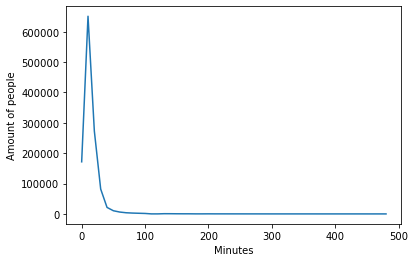

In [80]:
plt.plot(df_all_minutes['unique_minutes'],df_all_minutes['people'])
plt.xlabel('Minutes')
plt.ylabel('Amount of people')

Text(0, 0.5, 'Amount of people')

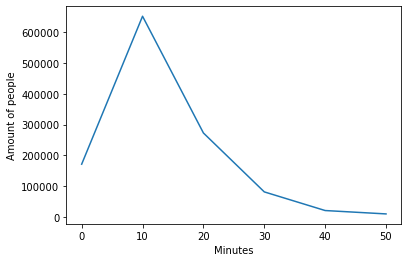

In [75]:
plt.plot(df_big_minutes['unique_minutes'],df_big_minutes['people'])
plt.xlabel('Minutes')
plt.ylabel('Amount of people')

Text(0, 0.5, 'Amount of people')

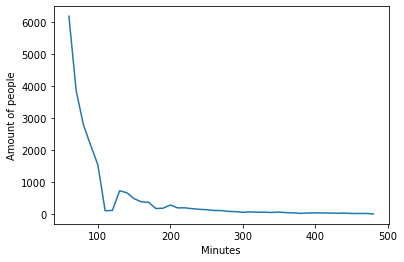

In [76]:
plt.plot(df_small_minutes['unique_minutes'],df_small_minutes['people'])
plt.xlabel('Minutes')
plt.ylabel('Amount of people')

### 1.5) Clustering